# import & data load系

In [25]:
# 基本のライブラリを読み込む
import numpy as np
import pandas as pd
from scipy import stats

# グラフ描画
from matplotlib import pylab as plt
import seaborn as sns
%matplotlib inline

# グラフを横長にする
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

# 統計モデル
import statsmodels.api as sm

# Prophet <- 要install
from fbprophet import Prophet
import sys,os
sys.path.append(os.pardir)

In [26]:
from DataReader import DataReader
dr = DataReader()
train_df, test_df = dr.get_raw_data()

# トレーニングデータから欠損値とclose=1を除く

In [27]:
# train_df = train_df[train_df.close==0]
# train_df = train_df[train_df.price_am!=-1]
# train_df = train_df[train_df.price_pm!=-1]

In [28]:
df = train_df[["datetime", "y"]]
df["ds"] = pd.to_datetime(df.datetime)
df = df.drop("datetime", axis=1)
df = df.reset_index()
len(df)

/Users/tatsukikoga/.pyenv/versions/anaconda3-4.1.1/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


2101

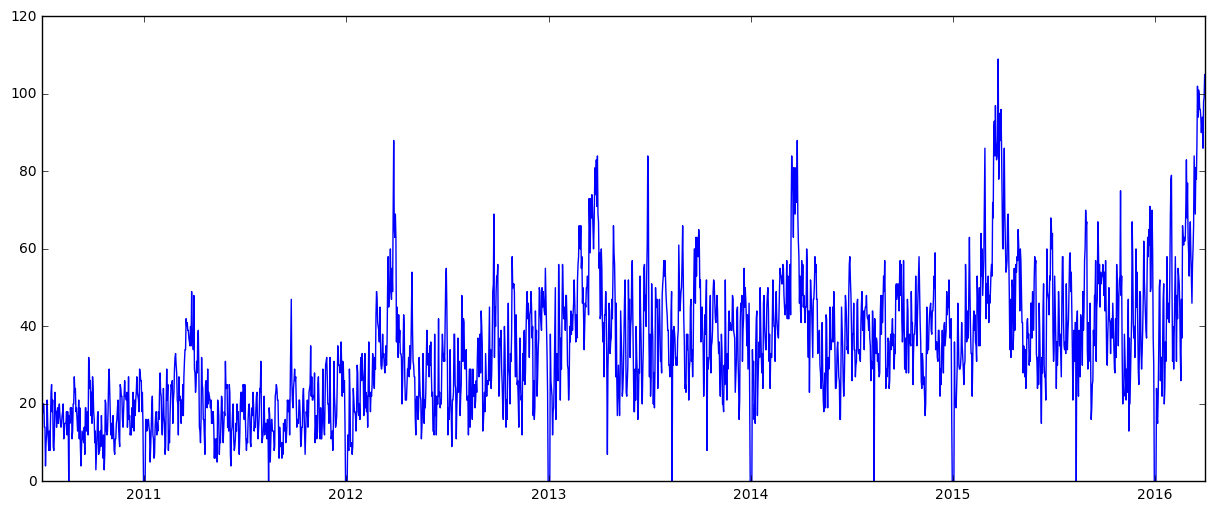

In [29]:
plt.plot(df.ds, df.y)

In [31]:
event_df_train = pd.DataFrame({
  'holiday': 'client_train',
  'ds': train_df[train_df.client == 1].datetime,
})
event_df_test = pd.DataFrame({
  'holiday': 'client_test',
  'ds': test_df[test_df.client == 1].datetime,
})

event_df = pd.concat((event_df_train, event_df_test))

def march_weekend(ds):
    date = pd.to_datetime(ds)
    if date.weekday() >= 5 and date.month == 3:
        return 1
    else:
        return 0
    
df['march_weekend'] = df['ds'].apply(march_weekend)

m = Prophet(weekly_seasonality=True, yearly_seasonality=True, holidays=event_df)
m.add_seasonality(name='monthly', period=30.5, fourier_order=5, prior_scale=10)
m.add_regressor('march_weekend', prior_scale=50)

m.fit(df)  # df is a pandas.DataFrame with 'y' and 'ds' columns
future = m.make_future_dataframe(periods=365)
future['march_weekend'] = future['ds'].apply(march_weekend)
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
len(forecast)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2466

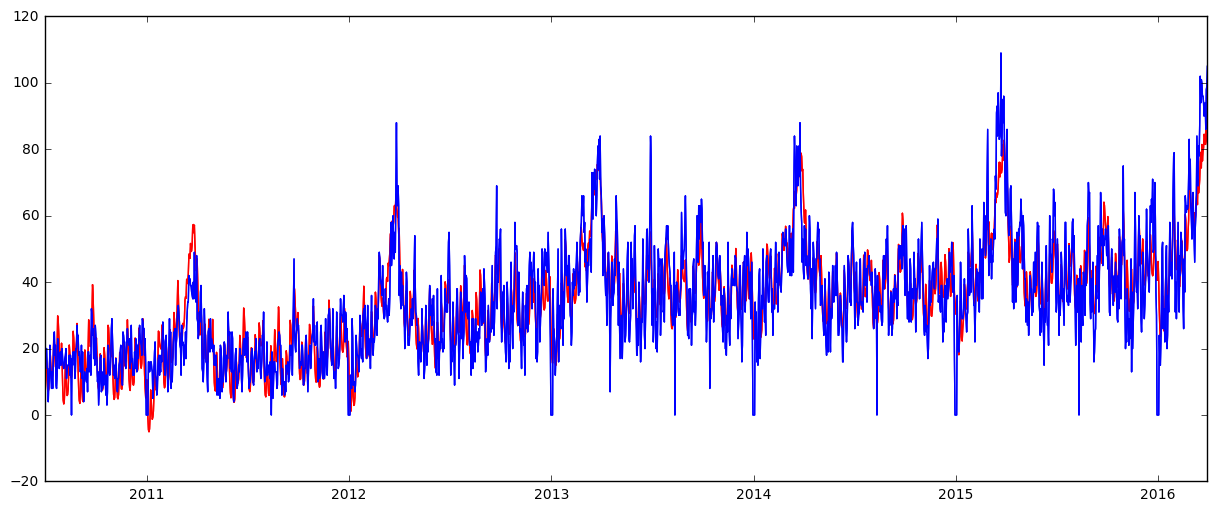

In [7]:
train_ans = forecast[:2101]
train_ans = train_ans.reset_index()
train_ans_ = pd.concat([train_ans, df], axis=1)
train_ans_["y_diff"] = train_ans_.y - train_ans_.yhat
plt.plot(train_ans_.ds, train_ans_.yhat, color='r')
plt.plot(train_ans_.ds, train_ans_.y, color='b')

In [8]:
# plt.plot(train_ans_.ds, train_ans_.y_diff)
train_ans_[["y", "yhat", "y_diff", "ds"]].head()

,y,yhat,y_diff,ds,ds
0,17,11.199581,5.800419,2010-07-01,2010-07-01
1,18,13.016560,4.983440,2010-07-02,2010-07-02
2,20,19.162614,0.837386,2010-07-03,2010-07-03
3,20,15.559348,4.440652,2010-07-04,2010-07-04
4,14,10.288636,3.711364,2010-07-05,2010-07-05


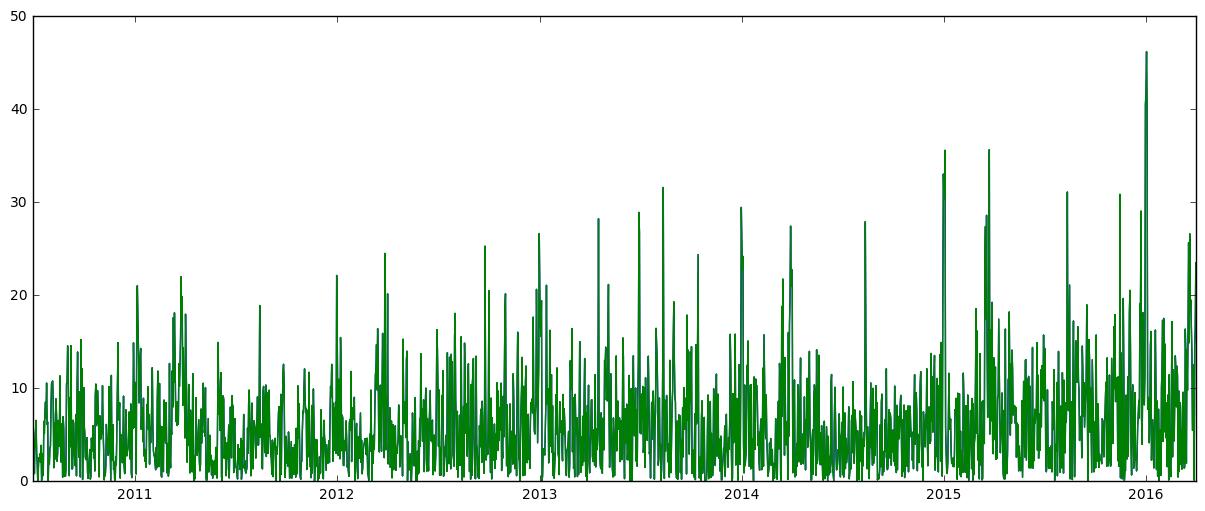

In [11]:
plt.plot(train_ans_.ds, abs(train_ans_.y_diff))

# trainでのMAE

In [23]:
sum(abs(train_ans_.y[1500:] - train_ans_.yhat[1500:])) / len(train_ans_[1500:])

7.4402268047795559

In [13]:
forecast[forecast.ds=='2016-04-01']

,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,client_test,client_test_lower,client_test_upper,client_train,...,seasonalities,seasonalities_lower,seasonalities_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,yhat
2101,2016-04-01,47.513285,47.513285,47.513285,68.619582,90.526068,0.0,0.0,0.0,0.0,...,32.161904,32.161904,32.161904,0.093935,0.093935,0.093935,24.223052,24.223052,24.223052,79.675188


In [14]:
ans = forecast[1889:]
len(ans) == len(test_df)

False

In [15]:
ans = ans.reset_index()
test_df = test_df.reset_index()

In [16]:
ans_ = pd.concat([ans, test_df], axis=1)
ans_

,index,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,client_test,client_test_lower,client_test_upper,...,yearly,yearly_lower,yearly_upper,yhat,index,datetime,client,close,price_am,price_pm
0,1889,2015-09-02,44.840728,44.840728,44.840728,28.017480,49.667661,0.0,0.0,0.0,...,-5.515909,-5.515909,-5.515909,38.784875,0.0,2016-04-01,1.0,0.0,3.0,2.0
1,1890,2015-09-03,44.853335,44.853335,44.853335,25.765872,46.982973,0.0,0.0,0.0,...,-5.475515,-5.475515,-5.475515,36.613346,1.0,2016-04-02,0.0,0.0,5.0,5.0
2,1891,2015-09-04,44.865941,44.865941,44.865941,27.320259,47.871861,0.0,0.0,0.0,...,-5.376112,-5.376112,-5.376112,38.011373,2.0,2016-04-03,1.0,0.0,2.0,2.0
3,1892,2015-09-05,44.878548,44.878548,44.878548,33.197626,53.281646,0.0,0.0,0.0,...,-5.214720,-5.214720,-5.214720,43.583457,3.0,2016-04-04,1.0,0.0,1.0,1.0
4,1893,2015-09-06,44.891154,44.891154,44.891154,27.898776,49.653614,0.0,0.0,0.0,...,-4.989802,-4.989802,-4.989802,39.335208,4.0,2016-04-05,0.0,0.0,1.0,1.0
5,1894,2015-09-07,44.903760,44.903760,44.903760,23.257504,44.052670,0.0,0.0,0.0,...,-4.701360,-4.701360,-4.701360,33.557328,5.0,2016-04-06,1.0,0.0,1.0,1.0
6,1895,2015-09-08,44.916367,44.916367,44.916367,20.362658,40.578270,0.0,0.0,0.0,...,-4.350993,-4.350993,-4.350993,30.575525,6.0,2016-04-07,1.0,0.0,1.0,1.0
7,1896,2015-09-09,44.928973,44.928973,44.928973,19.697716,40.684971,0.0,0.0,0.0,...,-3.941913,-3.941913,-3.941913,30.610268,7.0,2016-04-08,0.0,0.0,1.0,1.0
8,1897,2015-09-10,44.941580,44.941580,44.941580,21.216413,42.842380,0.0,0.0,0.0,...,-3.478916,-3.478916,-3.478916,32.061019,8.0,2016-04-09,1.0,0.0,2.0,2.0
9,1898,2015-09-11,44.954186,44.954186,44.954186,26.419279,47.007028,0.0,0.0,0.0,...,-2.968312,-2.968312,-2.968312,36.645035,9.0,2016-04-10,1.0,0.0,1.0,1.0


In [66]:
ans_['y_'] = (1 - ans_['close']) * ans_['yhat'] 

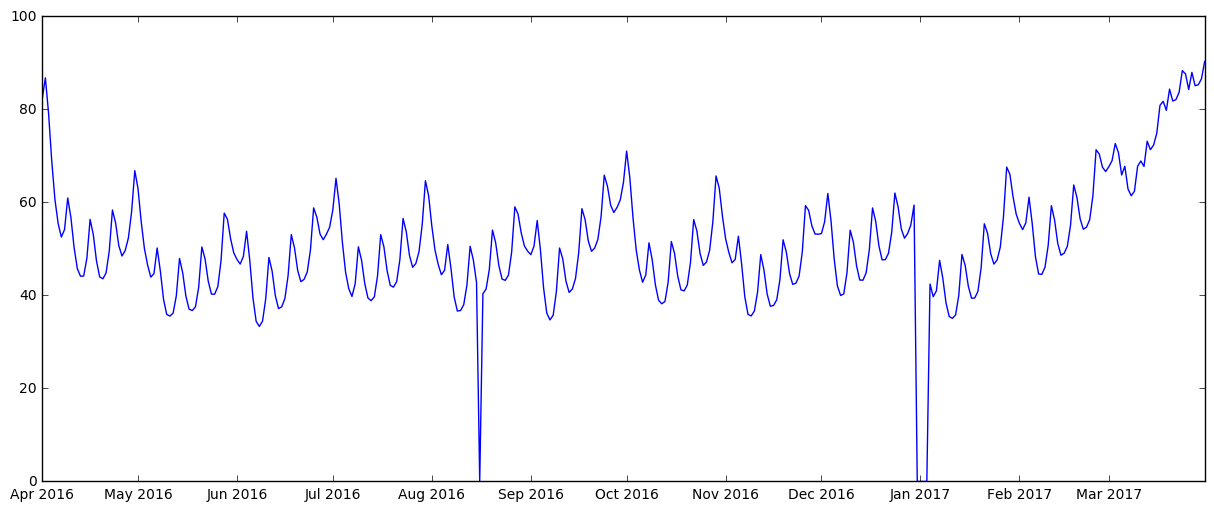

In [67]:
plt.plot(ans_.ds, ans_.y_)

In [68]:
print(ans_[ans_.client==1].y_.mean(), ans_[ans_.client==0].y_.mean())
print(train_df[train_df.client==1].y.mean(), train_df[train_df.client==0].y.mean())

53.185266137497976 49.00231911170099
50.577669902912625 34.57100415923945


In [71]:
submission = pd.concat([ans_.ds, ans_.y_], axis=1)
submission.to_csv("../data/submission.csv", index=False, header=False)

# 最新のsubmission score
-> 11.070203595200000

# 現状の問題点
- clientの情報がうまく取り込めていない？
- 周期性が強すぎる <- これはしょうがない気がする
    - アンサンブルすべき